In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Multivariate normal

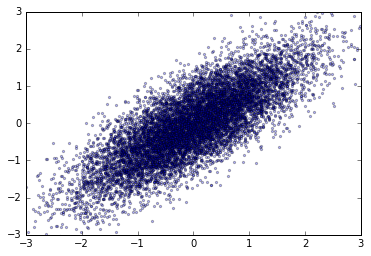

In [2]:
nsample = 10000
rho = 0.8
samples = np.random.multivariate_normal([0,0],[[1,rho],[rho,1]],nsample)

x,y = samples.T

fig,ax = plt.subplots(1,1)
ax.scatter(x,y,marker='.',alpha=0.3)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3);

In [3]:
def gibbs_bivariate_std_normal(rho,nsample):
    sample0 = (0,0)
    samples = np.zeros([nsample,2])
    samples[0,:] = sample0
    for isample in range(1,nsample):
        samples[isample,0] = np.sqrt(1-rho*rho)*np.random.randn() + rho*samples[isample-1,1]
        samples[isample,1] = np.sqrt(1-rho*rho)*np.random.randn() + rho*samples[isample,0]
    # end for isample
    return samples
# end def

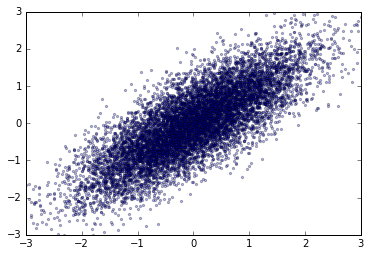

In [4]:
nsample = 10000
rho     = 0.8
my_samples = gibbs_bivariate_std_normal(rho,nsample)
myx,myy = my_samples.T

fig,ax = plt.subplots(1,1)
ax.scatter(myx,myy,marker='.',alpha=0.3)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3);

## Change-Point

In [3]:
from numpy.random import rand,randn,randint,poisson,gamma,multinomial
from scipy.special import factorial

In [7]:
# seed RNG for reproducibility
seed = 10
np.random.seed(seed)

# generate data
N=50
a=2
b=1
true_n = randint(N)
true_lam1 = gamma(a,1./b)
true_lam2 = gamma(a,1./b)
x = np.concatenate( [poisson(true_lam1,true_n)
                   , poisson(true_lam2,N-true_n)] )
print true_lam1,true_lam2

1.6013552149 0.218020080724


### Gibbs change-point

In [8]:
nequil = 0
nsample= 1000

# initialize model
n=randint(N)
lam1 = gamma(a,1./b)
lam2 = gamma(a,1./b)
ln_xfac = np.log( factorial(x) )

# make space for traces
trace_n = np.zeros(nsample,dtype=int)
trace_lam1 = np.zeros(nsample)
trace_lam2 = np.zeros(nsample)

# run MCMC 
for istep in range(nequil+nsample):
    
    # block sample new lambda1 and lambda2
    alam1 = a + sum(x[:n])
    blam1 = b + n
    alam2 = a + sum(x[n:])
    blam2 = b + (N-n)
    lam1 = gamma(alam1,1./blam1)
    lam2 = gamma(alam2,1./blam2)
    
    # sample new n
    mult_n = np.zeros(N)
    for i in range(N):
        #mult_n[i] = sum(x[:i])*np.log(lam1) - i*lam1 - i*sum(ln_xfac[:i]) +\
        #            sum(x[i:])*np.log(lam2) + i*lam2 + i*sum(ln_xfac[i:])
        mult_n[i] = sum(x[:i])*np.log(lam1) - i*lam1 + sum(x[i:])*np.log(lam2)+i*lam2# - i*sum(ln_xfac[:i])+i*sum(ln_xfac[i:]) 
    # end for i
    mult_n = np.exp(mult_n-max(mult_n))
    n = np.where( multinomial(1,mult_n/sum(mult_n))==1 )[0][0]
    
    if istep >= nequil:
        trace_n[istep-nequil]    = n
        trace_lam1[istep-nequil] = lam1
        trace_lam2[istep-nequil] = lam2
    # end if istep
    
# end for istep

In [10]:
print 'estimate:', np.mean(trace_n), np.mean(trace_lam1), np.mean(trace_lam2)
print 'true:    ', true_n,true_lam1,true_lam2

estimate: 9.617 1.30577670656 0.203822467148
true:     9 1.6013552149 0.218020080724


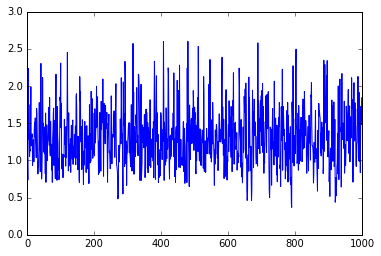

In [11]:
plt.plot(trace_lam1)

### Metropolis-Hasting

In [12]:
def ln_ppoisson(x,lam):
    return x*np.log(lam)-lam
# end def
def ln_pgamma(lam,a,b):
    return (a-1)*np.log(lam)-b*lam
# end def
def ln_prob(n,lam1,lam2):
    first  = sum( ln_ppoisson(x[:n],lam1) )
    second = sum( ln_ppoisson(x[n:],lam2) )
    plam1  = ln_pgamma(lam1,a,b)
    plam2  = ln_pgamma(lam2,a,b)
    return sum([first,second,plam1,plam2])
# end def

In [13]:
nequil = 0
nsample= 1000
nsubstep=80
sig = 0.05

# initialize model
n=randint(N)
lam1 = gamma(a,1./b)
lam2 = gamma(a,1./b)
old_ln_prob = ln_prob(n,lam1,lam2)

# make space for traces
trace_n = np.zeros(nsample,dtype=int)
trace_lam1 = np.zeros(nsample)
trace_lam2 = np.zeros(nsample)
naccept = 0

In [14]:
# run MCMC
for istep in range(nequil+nsample):
    
    for isub in range(nsubstep):
        # propose new lambda1, lambda2, and n
        new_lam1 = lam1 + sig*randn()
        new_lam2 = lam2 + sig*randn()
        new_n    = randint(N)

        new_ln_prob = ln_prob(new_n,new_lam1,new_lam2)

        accept = np.exp(new_ln_prob-old_ln_prob)
        if rand()<accept:
            lam1 = new_lam1
            lam2 = new_lam2
            n    = new_n
            naccept += 1
            old_ln_prob = new_ln_prob
        # end if
    # end for isub
    
    if istep >= nequil:
        trace_n[istep-nequil]    = n
        trace_lam1[istep-nequil] = lam1
        trace_lam2[istep-nequil] = lam2
    # end if istep
    
# end for istep

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


In [15]:
float(naccept)/(nsample*nsubstep)

0.06155

In [19]:
ndiscard = 800
print np.mean(trace_n[ndiscard:]),np.mean(trace_lam1[ndiscard:]),np.mean(trace_lam2[ndiscard:])
print true_n,true_lam1,true_lam2

9.95 1.08738706682 0.200051392298
9 1.6013552149 0.218020080724


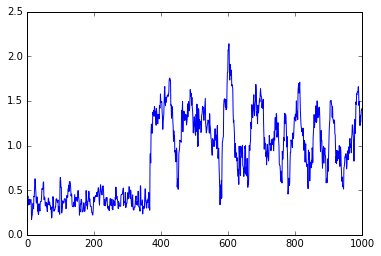

In [20]:
plt.plot(trace_lam1)